In [140]:
import pandas as pd
import numpy as np

# **1. Exploring and Cleaning the dataset**

In [141]:
# Load dataset
df = pd.read_csv('/content/diamonds.csv')

In [142]:
# First look
print(df.shape)
print(df.info())

(53947, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53947 entries, 0 to 53946
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53947 non-null  int64  
 1   carat       53947 non-null  float64
 2   cut         53944 non-null  object 
 3   color       53946 non-null  object 
 4   clarity     53947 non-null  object 
 5   depth       53946 non-null  float64
 6   table       53947 non-null  float64
 7   price       53947 non-null  int64  
 8   x           53947 non-null  float64
 9   y           53947 non-null  float64
 10  z           53947 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 4.5+ MB
None


Data Types:
* Numerical (7): carat, depth, table, price, x, y, Unnamed: 0
* Categorical (4): cut, color, clarity, z

Unnamed: 0 -> index and can be dropped

In [143]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [144]:
# Summary of numeric features
print(df.describe())

         Unnamed: 0         carat         depth         table         price  \
count  53947.000000  53947.000000  53946.000000  53947.000000  53947.000000   
mean   26973.000000      0.797936     61.749271     57.457143   3932.614158   
std    15573.301823      0.473981      1.432571      2.234418   3989.233934   
min        0.000000      0.200000     43.000000     43.000000   -200.000000   
25%    13486.500000      0.400000     61.000000     56.000000    950.000000   
50%    26973.000000      0.700000     61.800000     57.000000   2401.000000   
75%    40459.500000      1.040000     62.500000     59.000000   5324.000000   
max    53946.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y  
count  53947.000000  53947.000000  
mean       5.731181      5.734549  
std        1.121691      1.142063  
min        0.000000      0.000000  
25%        4.710000      4.720000  
50%        5.700000      5.710000  
75%        6.540000      6.540000  


In [145]:
# Summary of categorical features
print(df.select_dtypes(include='object').describe())

          cut  color clarity      z
count   53944  53946   53947  53947
unique      8      8      11    377
top     Ideal      G     SI1    2.7
freq    21549  11293   13064    767


### **EDA observations**
* Unnamed: 0 is just an index: Drop this column
* z column has wrong data types: Convert to numeric
* x, y have 0 values: Invalid dimensions, should be removed
* price has invalid negative values (min = -200): Must be removed


* y max = 58.9 : maybe outliers
* depth min = 43, max = 79: maybe outliers
* table ranges 43 - 95: Check outliers too

In [146]:
# Drop 'Unnamed: 0' as it's just an index
df.drop(columns=['Unnamed: 0'], inplace=True)

In [147]:
# Convert 'z' to numeric
df['z'] = pd.to_numeric(df['z'], errors='coerce')  # non-numeric becomes NaN

# Fill missing values with median
df['z'].fillna(df['z'].median(), inplace=True)

/tmp/ipython-input-2985699744.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['z'].fillna(df['z'].median(), inplace=True)


In [148]:
# Remove negative or zero prices
df = df[df['price'] > 0]

# Remove rows with x, y, z = 0 (not realistic)
df = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)]

In [149]:
# Check null values
df.isnull().sum()

,0
carat,0
cut,3
color,1
clarity,0
depth,1
table,0
price,0
x,0
y,0
z,0


5 missing values (very small) so we can either drop them or replace with proper values

In [150]:
# Impute missing values (by mode)
for col in ['cut', 'color', 'depth']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

In [151]:
# Check for duplicates
df.duplicated().sum()

np.int64(152)

In [152]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [153]:
# View unique values in each categorical column
for col in ['cut', 'color', 'clarity']:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'cut':
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair' 'very good' 'ideal' 'premium']

Unique values in 'color':
['E' 'I' 'J' 'H' 'F' 'G' 'D' '87']

Unique values in 'clarity':
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' '8' '7y' 'IF' 'vs2']


 The dataset has inconsistencies in all three categorical columns

In [154]:
# Fix
df['cut'] = df['cut'].str.strip().str.title()

df = df[df['color'].isin(['D', 'E', 'F', 'G', 'H', 'I', 'J'])] #remove 87

df['clarity'] = df['clarity'].str.strip().str.upper()
df = df[df['clarity'].isin(['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'I1'])]

/tmp/ipython-input-3991889416.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clarity'] = df['clarity'].str.strip().str.upper()


In [155]:
# Check
for col in ['cut', 'color', 'clarity']:
    print(f"\nCleaned unique values in '{col}':")
    print(df[col].unique())


Cleaned unique values in 'cut':
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']

Cleaned unique values in 'color':
['E' 'I' 'J' 'H' 'F' 'G' 'D']

Cleaned unique values in 'clarity':
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


# **2. Visualization**

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

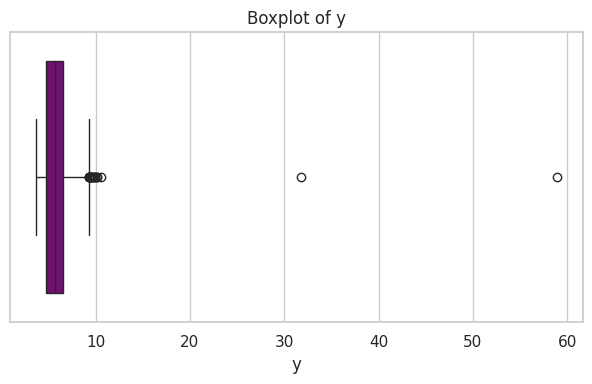

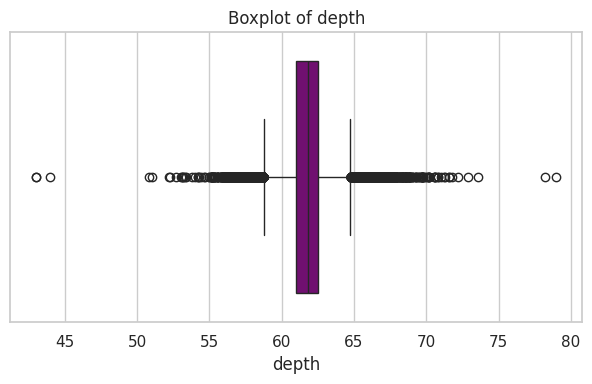

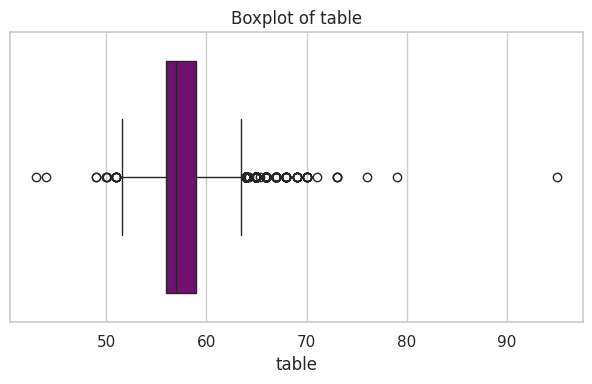

In [157]:
# Check outliers

cols_to_check = ['y', 'depth', 'table']

for col in cols_to_check:
    plt.figure(figsize=(12, 4))

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='purple')
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

### **Insights:**
* y: Extreme outliers, heavily left-skewed.
* depth: Outliers on both sides, slight right-skew.
* table: Outliers on both sides, slight right-skew, and central clustering.

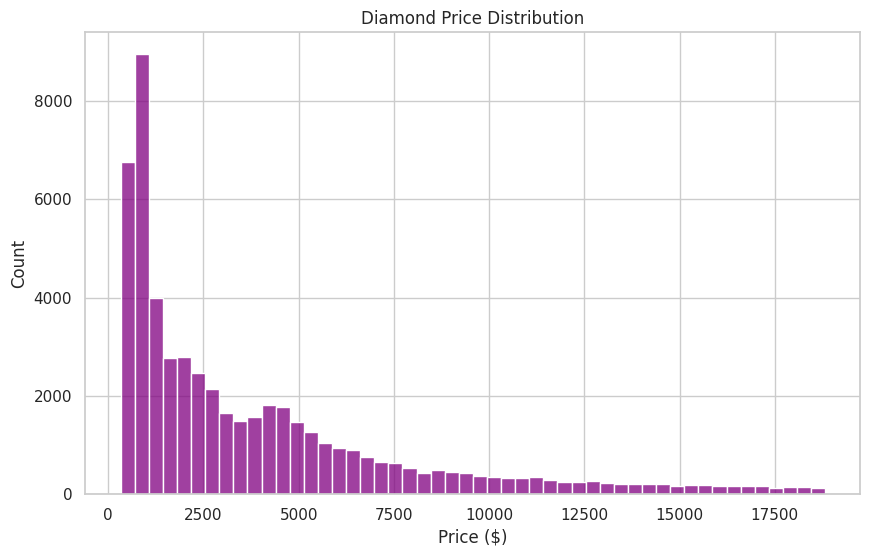

In [158]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], color='Purple', bins=50)
plt.title('Diamond Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### **Insights:**
* The diamond price distribution is right-skewed, with most diamonds being relatively inexpensive.
* A few diamonds have very high prices.

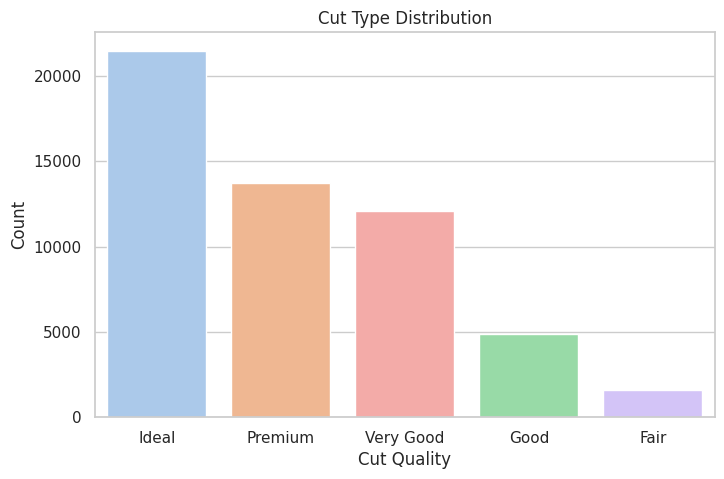

In [159]:
# Cut dist.
plt.figure(figsize=(8, 5))
sns.countplot(x='cut', data=df, hue='cut', palette='pastel', order=df['cut'].value_counts().index, legend=False)
plt.title('Cut Type Distribution')
plt.xlabel('Cut Quality')
plt.ylabel('Count')
plt.show()

### **Insights:**
* "Ideal" is the most common cut type, followed by "Premium" and "Very Good."
* "Good" and "Fair" cuts are less frequent, with "Fair" being the rarest.

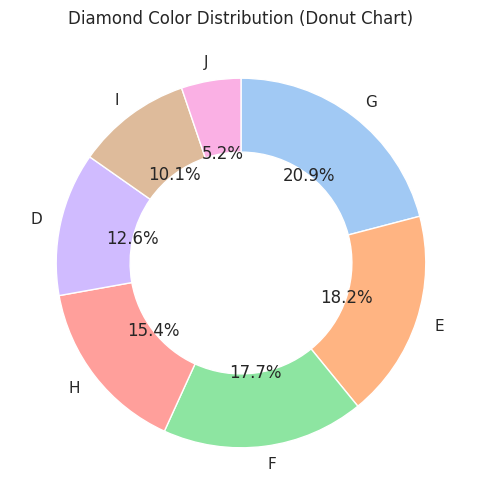

In [160]:
# Donut chart for color
color_counts = df['color'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(color_counts, labels=color_counts.index, startangle=90, counterclock=False, wedgeprops=dict(width=0.4), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Diamond Color Distribution (Donut Chart)')
plt.show()

### **Insights:**
* G, F, and E are the most common diamond colors, accounting for over half of the dataset.
* D, H, I, and J are less frequent but still present.

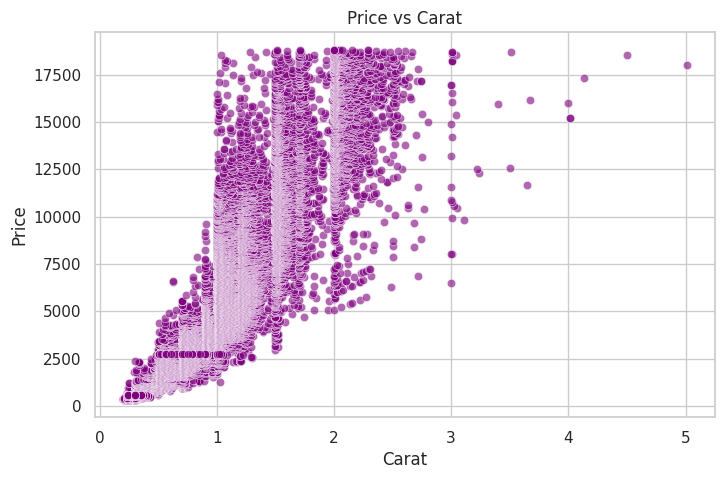

In [161]:
# Scatter plot: price vs carat
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='carat', y='price', alpha=0.6, color='Purple')
plt.title('Price vs Carat')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### **Insights:**
* Carat strongly influences price, but other factors also play a role in determining the final price.
* Most diamonds in the dataset are small (low carat), while larger diamonds are less common but show more price variability.

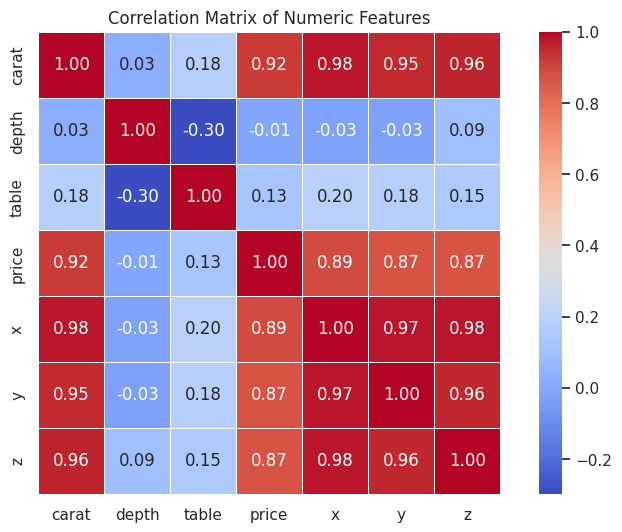

In [162]:
# Correlation matrix
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)  # Exclude non-numeric columns
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### **Insights:**
* Carat and price are strongly correlated, reflecting their direct relationship.
* Physical dimensions (x, y, z) are highly interrelated, showing consistency in diamond shape.
* Depth has limited correlations, suggesting it may capture unique aspects of diamond structure.
* Table shows a moderate inverse relationship with depth but weak relationships with other features.

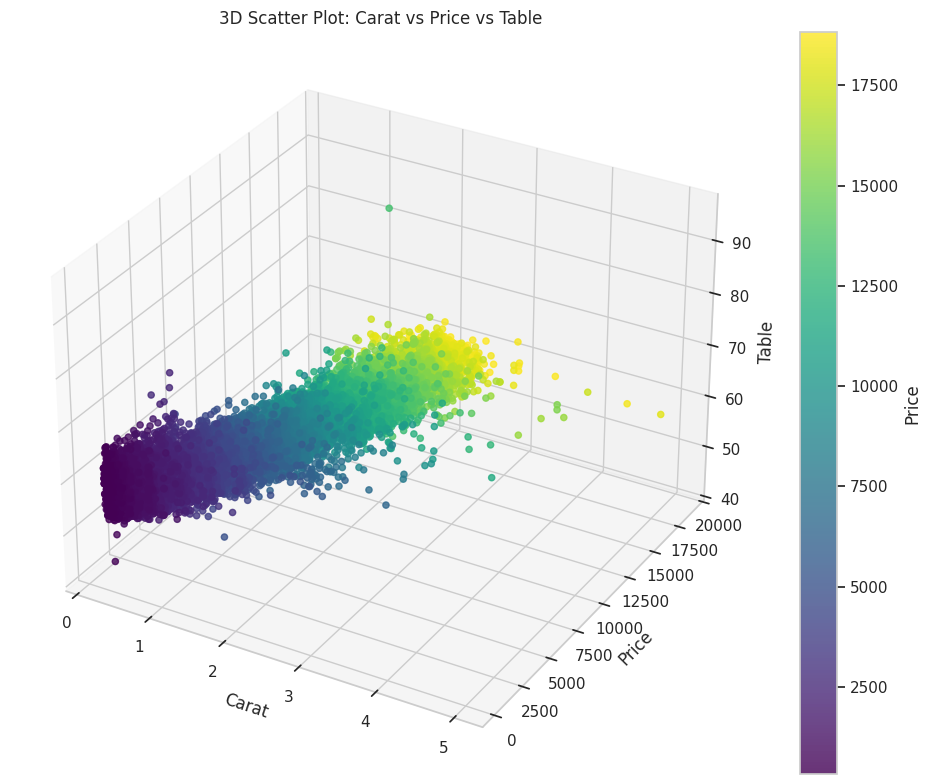

In [163]:
# 3D Scatter Plot: Carat vs Price vs Table

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df['carat'], df['price'], df['table'],
                c=df['price'], cmap='viridis', s=20, alpha=0.8)

# Labels
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
ax.set_zlabel('Table')
ax.set_title('3D Scatter Plot: Carat vs Price vs Table')

# Color bar (based on price)
plt.colorbar(sc, label='Price')

# Show plot
plt.tight_layout()
plt.show()

### **Insights:**
* Carat is the dominant factor influencing price.
* Table percentage shows moderate variability but does not appear to be the primary determinant of price.


# **3. Encoding Categorical Data**

## Label Encoding vs One-Hot Encoding

### Label Encoding
- Assigns each unique category a number.
- Example: `Fair` :0, `Good`:1, `Ideal`:2.
- Best used when the categorical variable has **an inherent order** (ordinal data).
- Pros:
  - Simple and memory efficient.
- Cons:
  - May introduce a false sense of order or priority in the data.

### One-Hot Encoding
- Creates a **new binary column** for each category.
- Example:
  - For categories `Blue`, `Green`, `Red`, it creates 3 columns:
    - `Blue` → [1, 0, 0]
    - `Green` → [0, 1, 0]
    - `Red` → [0, 0, 1]
- Best used when the categorical variable has **no order** (nominal data).
- Pros:
  - Avoids false relationships between categories.
- Cons:
  - Can lead to **high dimensionality** if the number of categories is large.

### Summary
- Use **Label Encoding** when the data is **ordinal** (ordered).
- Use **One-Hot Encoding** when the data is **nominal** (unordered).


In [164]:
# Label encoding cut (Ordinal)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['cut_encoded'] = label_encoder.fit_transform(df['cut'])

In [165]:
# One-Hot encoding color and clarity (Nominal)
df = pd.get_dummies(df, columns=['color', 'clarity'], drop_first=True, dtype=int)

In [166]:
# Check first 5 rows
df.head()

,carat,cut,depth,table,price,x,y,z,cut_encoded,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,2,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,3,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,3,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,1,0,...,0,0,1,0,0,1,0,0,0,0


# **Scale Numeric Data**

### **Why Do We Scale the Data?**
1. **Features have different ranges.**
  - Some columns (features) have small numbers (like age = 20),
others have big numbers (like salary = 100,000).
  - This makes the big numbers more important than small ones in many models.
  - Example: A model may think "salary" is more important just because it has larger values.

2. **Some models use distance math to compare data points.**
  - like: K-Nearest Neighbors (KNN), Support Vector Machine (SVM), Linear Regression, use distance

  - If features are not scaled, these models give wrong results.

3. **Faster and Better Training.**
  - Some models (like neural networks) learn faster when the data is scaled.
  - The model reaches better accuracy in less time.

### **Common Scaling Methods**
1. **Standard Scaler**
  - Makes the data like a bell shape (normal distribution).
  - The average becomes 0 and the spread becomes 1.
  - Best for data that looks "normal.

2. **Robust Scaler**
  - Ignores outliers (very big or small values).
  - Good when your data has extreme values.

3. **Min-Max Scaler**
  - Turns all values into a range from 0 to 1.
  - Works well if there's no outliers.

4. **Log or Power Transform**
  - Used when some values are too skewed (very spread out).
  - It helps make the data look more balanced.

In [167]:
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# Copy of the data
df_scaled = df.copy()

# Apply log transform to 'price'
df_scaled['price'] = np.log1p(df_scaled['price'])

# Initialize scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Standard scaling for normally distributed column
df_scaled['depth'] = standard_scaler.fit_transform(df_scaled[['depth']])

# Robust scaling for columns with outliers
cols_robust = ['carat', 'table', 'x', 'y', 'z']
df_scaled[cols_robust] = robust_scaler.fit_transform(df_scaled[cols_robust])

df_scaled.head()

,carat,cut,depth,table,price,x,y,z,cut_encoded,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.734375,Ideal,-0.173544,-0.666667,5.789960,-0.956284,-0.950549,-0.982143,2,1,...,0,0,0,0,0,1,0,0,0,0
1,-0.765625,Premium,-1.362742,1.333333,5.789960,-0.989071,-1.027473,-1.089286,3,1,...,0,0,0,0,1,0,0,0,0,0
2,-0.734375,Good,-3.391374,2.666667,5.793014,-0.901639,-0.901099,-1.089286,1,1,...,0,0,0,0,0,0,1,0,0,0
3,-0.640625,Premium,0.456031,0.333333,5.814131,-0.819672,-0.813187,-0.803571,3,0,...,0,1,0,0,0,0,0,1,0,0
4,-0.609375,Good,1.085607,0.333333,5.817111,-0.743169,-0.747253,-0.696429,1,0,...,0,0,1,0,0,1,0,0,0,0


**StandardScaler:** Works like giving all values in a column a fair starting point (center = 0) and same unit of scale (like height in meters). Works best when data is normal.

**RobustScaler:** Ignores outliers and uses the middle range of data, so if there are some crazy large or small numbers, they don’t mess it up.

**Log transform:** Shrinks large values (like prices), so differences aren’t huge. Great for very skewed data.

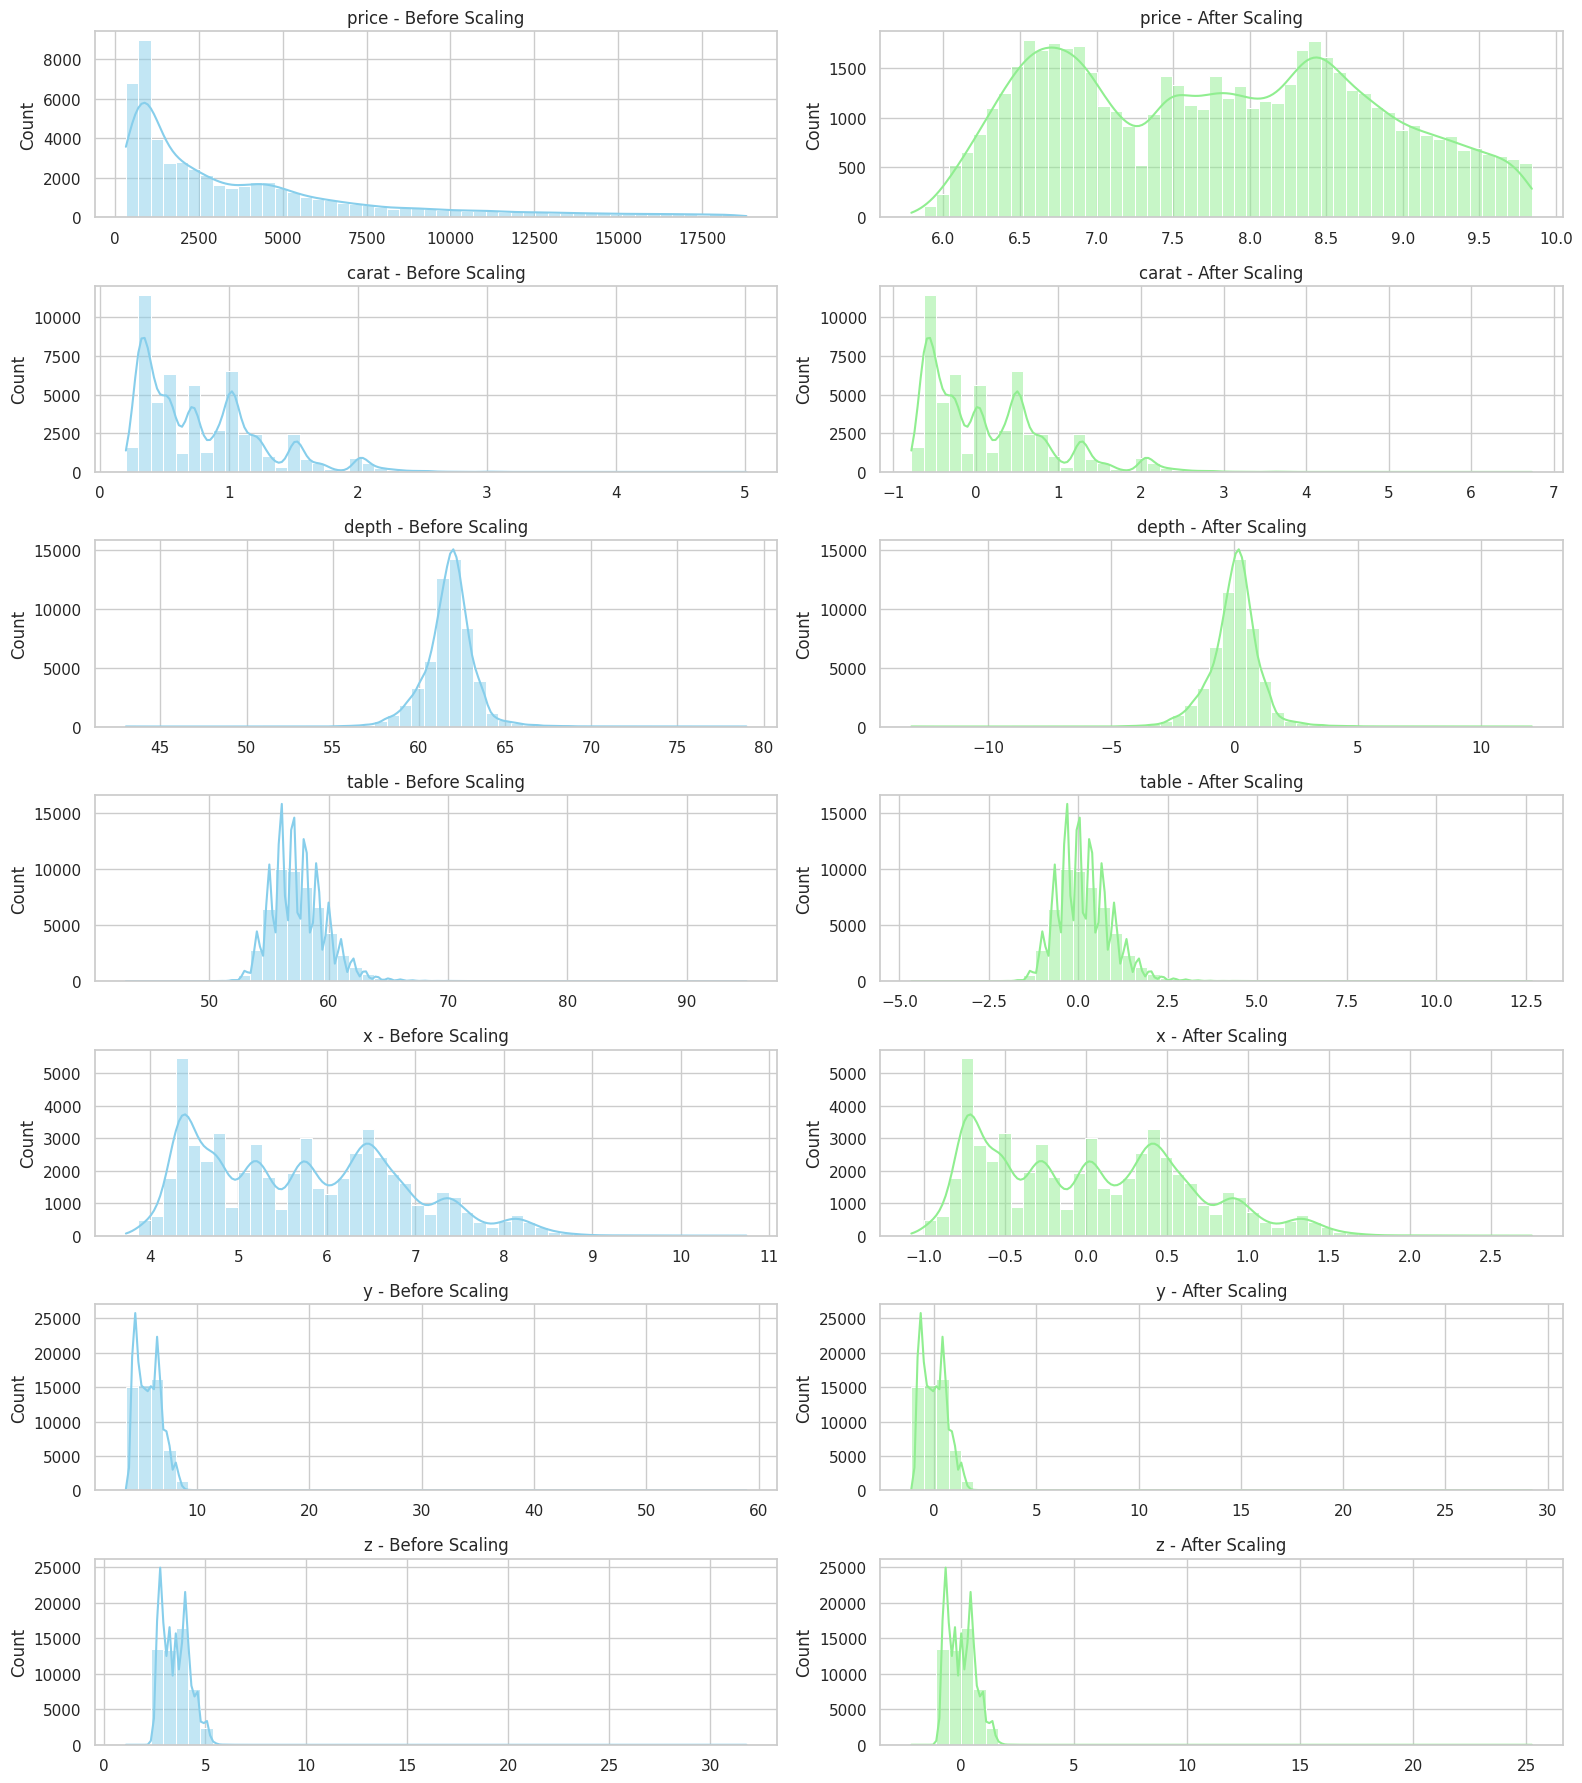

In [168]:
# Columns to visualize
columns_to_plot = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

# Set up the plot
plt.figure(figsize=(16, 18))

for i, col in enumerate(columns_to_plot):
    # Before scaling
    plt.subplot(len(columns_to_plot), 2, 2*i + 1)
    sns.histplot(df[col], kde=True, bins=50, color='skyblue')
    plt.title(f'{col} - Before Scaling')
    plt.xlabel('')

    # After scaling
    plt.subplot(len(columns_to_plot), 2, 2*i + 2)
    sns.histplot(df_scaled[col], kde=True, bins=50, color='lightgreen')
    plt.title(f'{col} - After Scaling')
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [169]:
# Saving cleaned and scaled dataset
df_scaled.to_csv('clean_diamonds.csv', index=False)